In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm.classes import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import RandomForestRegressor

### Prediction latencies

https://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py

In [2]:
def generate_dataset(n_samples, n_features, noise=0.1):
    
    print("generating dataset...")

    X, y, coef = make_regression(n_samples=n_samples,
                                 n_features=n_features, 
                                 noise=noise, coef=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    
    print('dataset generation complete...')
    
    return X_train, y_train, X_test, y_test

In [3]:
def build_and_train_model(X_train, y_train, model):
    
    model.fit(X_train, y_train)

In [4]:
X_train, y_train, X_test, y_test = generate_dataset(10000, 100)

generating dataset...
dataset generation complete...


In [5]:
X_train.shape, y_train.shape

((8000, 100), (8000,))

In [6]:
X_test.shape, y_test.shape

((2000, 100), (2000,))

In [9]:
linear_model = LinearRegression()

lasso_model = Lasso(alpha=0.8)

sgd_model = SGDRegressor(penalty='elasticnet', alpha=0.01,
                         l1_ratio=0.25, tol=1e-4)

sv_model = SVR(kernel='rbf', gamma='scale')

dt_model = DecisionTreeRegressor(max_depth=10)

rf_model = RandomForestRegressor(n_estimators=20)

In [10]:
build_and_train_model(X_train, y_train, linear_model)

build_and_train_model(X_train, y_train, lasso_model)

build_and_train_model(X_train, y_train, sgd_model)

build_and_train_model(X_train, y_train, sv_model)

build_and_train_model(X_train, y_train, dt_model)

build_and_train_model(X_train, y_train, rf_model)

In [11]:
def bulk_predict_using_model(X_test, y_test, model):
    
    prediction_latencies = []
    
    for i in range(20):
        start = time.time()
        y_pred = model.predict(X_test)
        
        prediction_latencies.append(time.time() - start)
        
   
    return prediction_latencies

In [12]:
bulk_prediction_latencies_dict = {}

In [13]:
bulk_prediction_latencies_dict['linear'] = bulk_predict_using_model(X_test, 
                                                                    y_test, 
                                                                    linear_model)

bulk_prediction_latencies_dict['lasso'] = bulk_predict_using_model(X_test, 
                                                                   y_test, 
                                                                   lasso_model)

bulk_prediction_latencies_dict['sgd'] = bulk_predict_using_model(X_test, 
                                                                 y_test, 
                                                                 sgd_model)

bulk_prediction_latencies_dict['sv'] = bulk_predict_using_model(X_test, 
                                                                y_test, 
                                                                sv_model)

bulk_prediction_latencies_dict['dt'] = bulk_predict_using_model(X_test, 
                                                                y_test, 
                                                                dt_model)

bulk_prediction_latencies_dict['rf'] = bulk_predict_using_model(X_test, 
                                                                y_test, 
                                                                rf_model)

In [14]:
bulk_prediction_latencies_df = pd.DataFrame()

for key in bulk_prediction_latencies_dict:
    bulk_prediction_latencies_df[key] = bulk_prediction_latencies_dict[key]

In [15]:
bulk_prediction_latencies_df

,linear,lasso,sgd,sv,dt,rf
0,0.002303,0.002718,0.000414,0.744678,0.001260,0.015284
1,0.004138,0.000501,0.000316,0.722015,0.000693,0.012461
2,0.000617,0.000347,0.000294,0.731410,0.000681,0.011231
3,0.001090,0.000542,0.000286,0.915748,0.000712,0.010175
4,0.000588,0.000458,0.000279,0.738948,0.000688,0.011845
5,0.000420,0.000362,0.000279,0.926043,0.000677,0.012174
6,0.000326,0.000330,0.000283,0.803290,0.000644,0.010332
7,0.000309,0.000362,0.000293,0.691721,0.000676,0.011210
8,0.000498,0.000317,0.000298,0.680025,0.000695,0.010650
9,0.000530,0.000554,0.000328,0.689053,0.000827,0.010710


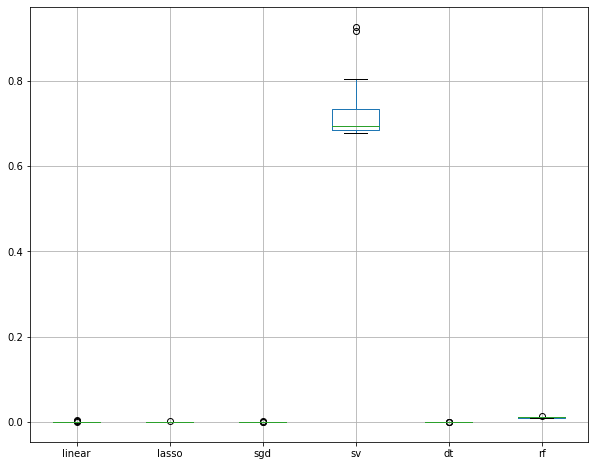

In [16]:
bulk_prediction_latencies_df.boxplot(figsize=(10, 8))

In [17]:
def atomic_predict_using_model(X_test, y_test, model):
    
    prediction_latencies = []
    
    for i in range(X_test.shape[0]):
        start = time.time()
        y_pred = model.predict(X_test[i].reshape(1, -1))
        
        prediction_latencies.append(time.time() - start)
        
    prediction_latencies = np.array(prediction_latencies)
    
    return [np.percentile(prediction_latencies, 50)]

In [18]:
atomic_prediction_latencies_dict = {}

In [19]:
atomic_prediction_latencies_dict['linear'] = atomic_predict_using_model(X_test, 
                                                                        y_test, 
                                                                        linear_model)

atomic_prediction_latencies_dict['lasso'] = atomic_predict_using_model(X_test, 
                                                                       y_test, 
                                                                       lasso_model)

atomic_prediction_latencies_dict['sgd'] = atomic_predict_using_model(X_test, 
                                                                     y_test, 
                                                                     sgd_model)

atomic_prediction_latencies_dict['sv'] = atomic_predict_using_model(X_test, 
                                                                    y_test, 
                                                                    sv_model)

atomic_prediction_latencies_dict['dt'] = atomic_predict_using_model(X_test, 
                                                                    y_test, 
                                                                    dt_model)

atomic_prediction_latencies_dict['rf'] = atomic_predict_using_model(X_test, 
                                                                    y_test, 
                                                                    rf_model)

In [20]:
atomic_prediction_latencies_df = pd.DataFrame()

for key in atomic_prediction_latencies_dict:
    atomic_prediction_latencies_df[key] = atomic_prediction_latencies_dict[key]

In [21]:
atomic_prediction_latencies_df

,linear,lasso,sgd,sv,dt,rf
0,0.000044,0.000046,0.000043,0.0005,0.000053,0.001139


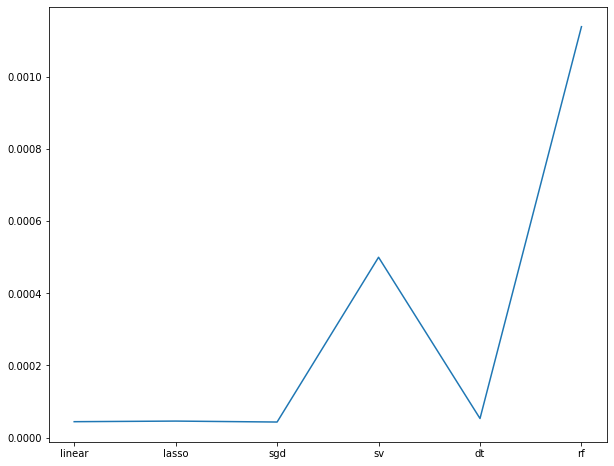

In [22]:
plt.figure(figsize=(10, 8))

plt.plot(atomic_prediction_latencies_df.iloc[0])